In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow import data as tf_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/dataset.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Old English sheepdog/n02105641_1254.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_1257.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_12586.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_126.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_12610.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_12614.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_12623.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_12645.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_12655.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_12665.JPEG  
 extracting: /content/dataset/Old English sheepdog/n02105641_12668.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_12673.JPEG  
  inflating: /content/dataset/Old English sheepdog/n02105641_1268

In [4]:
data_dir = pathlib.Path('/content/dataset')
batch_size = 64
image_height = 224
image_width = 224
image_size = (224, 224)



In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(image_height, image_width),
    batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(image_height, image_width),
    batch_size=batch_size)



Found 12454 files belonging to 10 classes.
Using 9964 files for training.
Found 12454 files belonging to 10 classes.
Using 2490 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Australian terrier', 'Beagle', 'Border terrier', 'Dingo', 'English foxhound', 'Golden retriever', 'Old English sheepdog', 'Rhodesian ridgeback', 'Samoyed', 'Shih-Tzu']


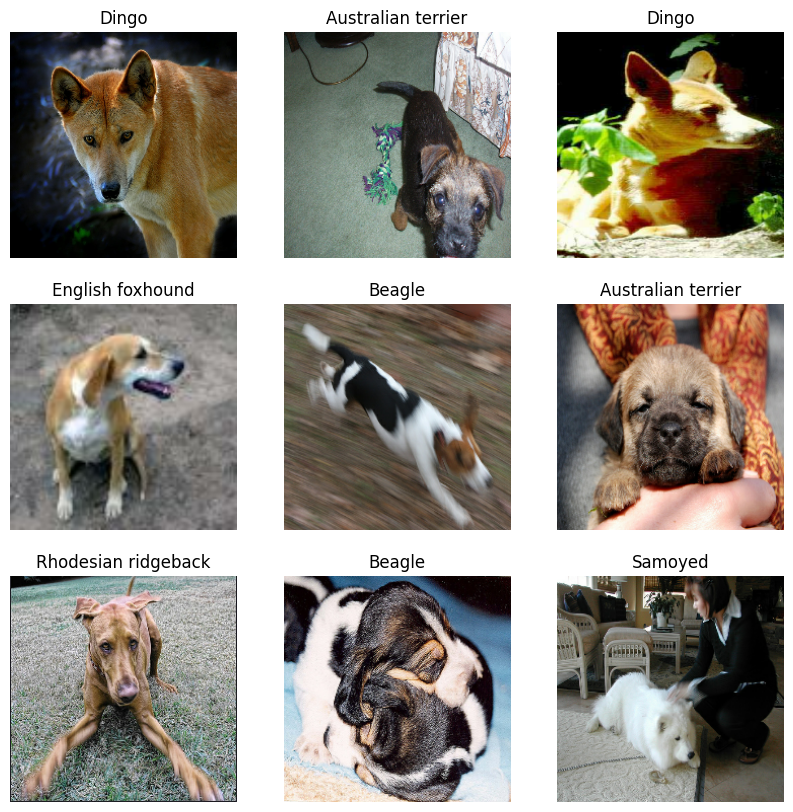

In [7]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

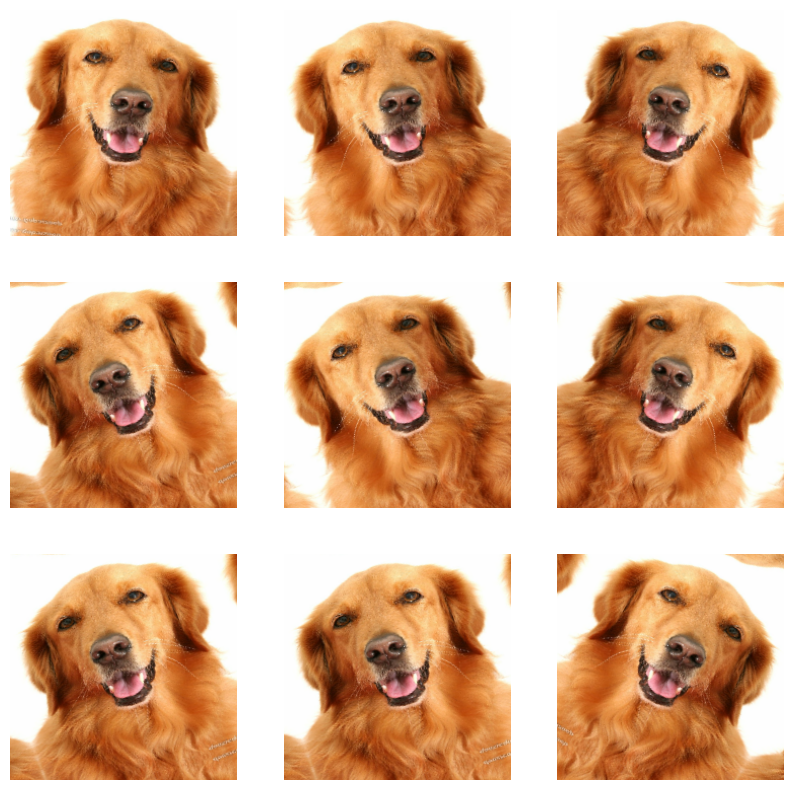

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


In [10]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

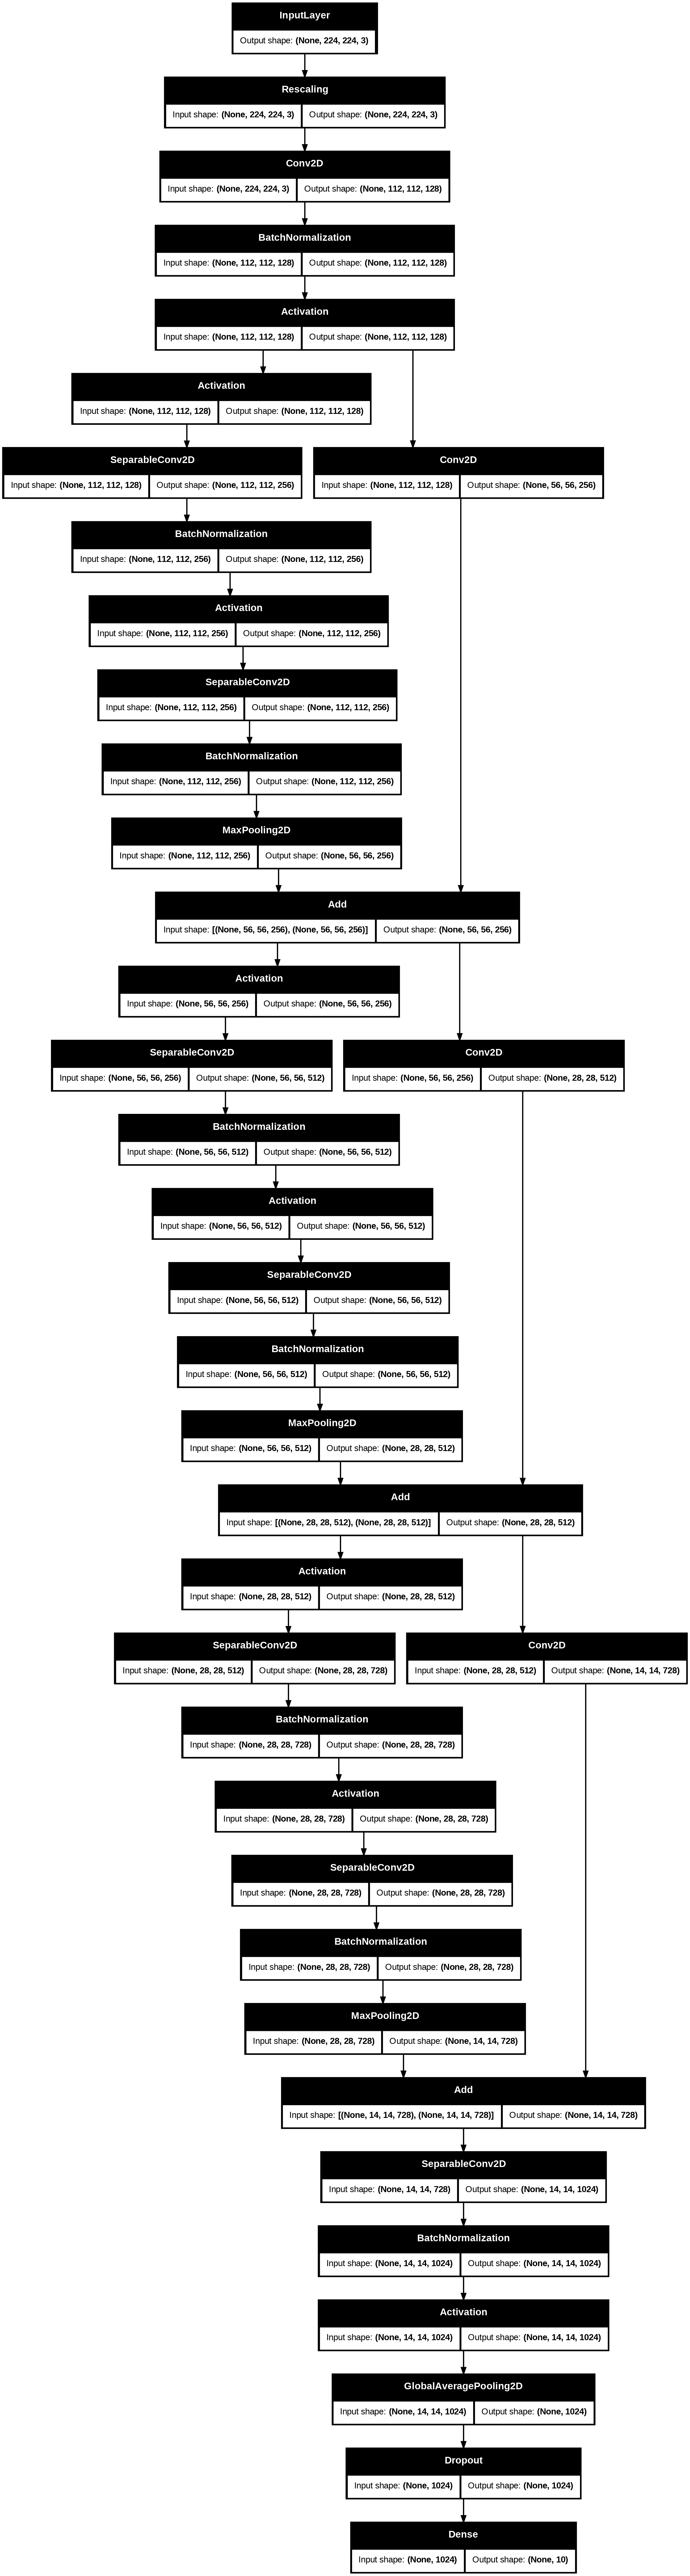

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.5)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=10)
keras.utils.plot_model(model, show_shapes=True)

In [12]:
epochs = 40

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.1807 - loss: 2.3114 - val_accuracy: 0.1016 - val_loss: 2.2989
Epoch 2/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 130s 829ms/step - accuracy: 0.3024 - loss: 1.9461 - val_accuracy: 0.1016 - val_loss: 2.3192
Epoch 3/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 129s 826ms/step - accuracy: 0.3710 - loss: 1.7587 - val_accuracy: 0.1012 - val_loss: 2.4351
Epoch 4/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 127s 811ms/step - accuracy: 0.4332 - loss: 1.5923 - val_accuracy: 0.1631 - val_loss: 2.3478
Epoch 5/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 128s 812ms/step - accuracy: 0.4783 - loss: 1.4706 - val_accuracy: 0.3502 - val_loss: 1.8237
Epoch 6/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 130s 829ms/step - accuracy: 0.5120 - loss: 1.3760 - val_accuracy: 0.5341 - val_loss: 1.4138
Epoch 7/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 129s 823ms/step - accuracy: 0.5566 - loss: 1.2680 - val_accuracy: 0.5341 - val_loss: 1.4380
Epoch 8/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 142s 821ms/step - accuracy: 0.5928 - lo

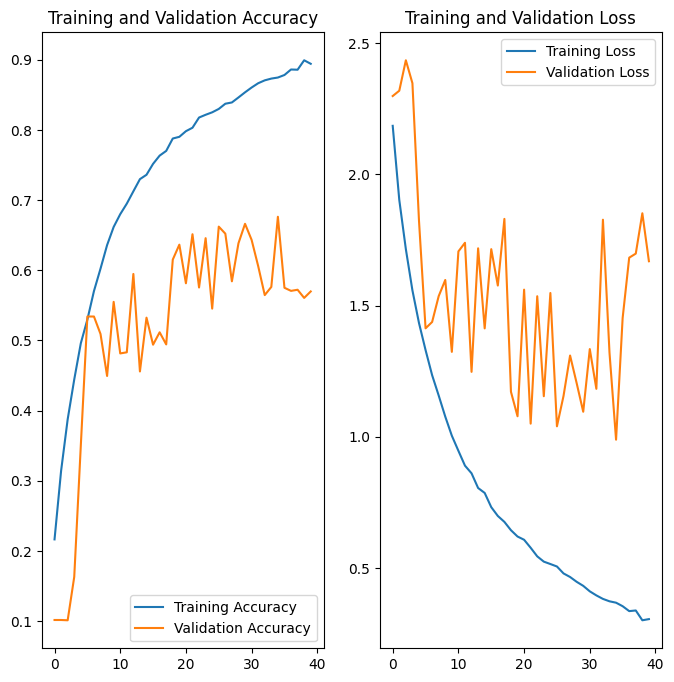

In [13]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

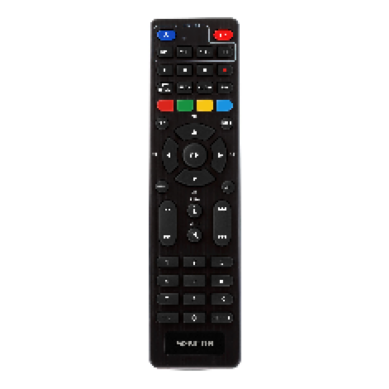

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Australian terrier: 5.51%
Beagle: 3.09%
Border terrier: 3.43%
Dingo: 8.04%
English foxhound: 0.24%
Golden retriever: 4.47%
Old English sheepdog: 17.87%
Rhodesian ridgeback: 3.51%
Samoyed: 48.66%
Shih-Tzu: 5.19%

This image is most likely a Samoyed with 48.66% confidence.


In [14]:
img = keras.utils.load_img("/content/drive/MyDrive/test-images/remote.jpg", target_size=image_size)
plt.imshow(img)
plt.axis("off")  # Hide axis for better visualization
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)
probabilities = keras.ops.softmax(predictions[0])  # Convert logits to probabilities

# Format and display the breed probabilities
for breed, prob in zip(class_names, probabilities.numpy()):
    print(f"{breed}: {100 * prob:.2f}%")

# Identify the top predicted breed
top_breed_index = np.argmax(probabilities)
top_breed = class_names[top_breed_index]
top_confidence = 100 * probabilities[top_breed_index]

print(f"\nThis image is most likely a {top_breed} with {top_confidence:.2f}% confidence.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


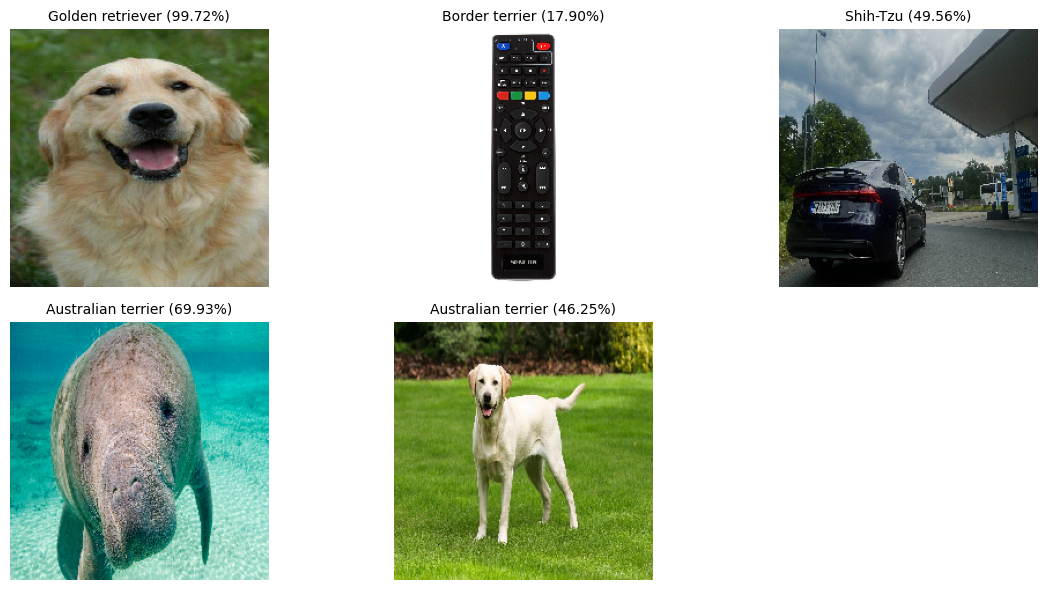

In [16]:
model = keras.models.load_model("/content/save_at_31.keras")


test_folder = "/content/drive/MyDrive/test-images"  # Folder containing test images
image_size = (224, 224)  # Ensure this matches your model's input size


image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# Number of images to display
num_images = min(len(image_files), 12)  # Adjust to show fewer/more images

# Set up plot
cols = 3  # Number of columns
rows = (num_images // cols) + (num_images % cols > 0)  # Calculate required rows
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))

# Loop through images and make predictions
for idx, image_file in enumerate(image_files[:num_images]):
    image_path = os.path.join(test_folder, image_file)

    # Load and preprocess image
    img = keras.utils.load_img(image_path, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

    # Make predictions
    predictions = model.predict(img_array)
    probabilities = keras.ops.softmax(predictions[0])  # Convert logits to probabilities

    # Identify the top predicted breed
    top_breed_index = np.argmax(probabilities)
    top_breed = class_names[top_breed_index]
    top_confidence = 100 * probabilities[top_breed_index]

    # Plot image
    ax = axes[idx // cols, idx % cols]  # Position in grid
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{top_breed} ({top_confidence:.2f}%)", fontsize=10)

# Hide any unused subplots (if images are less than grid size)
for i in range(idx + 1, rows * cols):
    fig.delaxes(axes[i // cols, i % cols])

plt.tight_layout()
plt.show()